In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import scipy as sc
from scipy.sparse import diags

function for vec operator

In [2]:
def vec(mA):
    return (mA.ravel('F')) #F means 按列stack
#give you a row

Function for time-series or cross-sectional de-meaning

In [3]:
def Demean(mA, iAxis):
    
    if iAxis == 0:

        mA = mA - np.mean(mA,axis=iAxis).reshape(1,int(np.shape(mA)[1-iAxis]))
    else:
        mA = mA - np.mean(mA,axis=iAxis).reshape(int(np.shape(mA)[1-iAxis]),1)

    return mA

A useful function to create a [T-1 x N] matrix of first differences out of a [T x N] matrix of raw data. A useful function for the AH estimators

In [4]:
def DiffMatrix(mInput, iLag):
    
    mOutput = np.roll(mInput, iLag,axis=0)
    mOutput[:iLag,:] = 0
    mDiff = mInput - mOutput
    
    return mDiff[iLag:,:]
#first difference

You can also de-mean over one axis first, and after de-mean over the second axis. This is useful for Fixed Effects estimators

A useful function to create a [T-1 x N] matrix of $l$-th lags out of a [T x N] matrix of raw data. A useful function for the AH estimators.

In [6]:
def LagMatrix(mInput, iLag):
    
    mOutput = np.roll(mInput, iLag,axis=0)
    mOutput[:iLag,:] = 0
       
    return mOutput[1:,:]  

Below is the function that can be used to generate the data

In [7]:
def GenrData (iSizeT, iSizeN, dAlpha, dDelta,dSigma2_eta):

    mErrors  = np.random.randn(iSizeT+1,iSizeN)
    
    vEta = np.sqrt(dSigma2_eta)*np.random.randn(1,iSizeN)
    
    mDataY = np.zeros((iSizeT+1,iSizeN))
    mDataY[0,:] = dDelta*vEta/(1-dAlpha) + np.sqrt(1-np.power(dAlpha,2))*mErrors[0,:]
    
    for t in range (1,iSizeT+1):       
        mDataY[t,:] = dAlpha * mDataY[t-1,:] + vEta + mErrors[t,:]
 
    # Note that this matrix is of dimension [T+1 x N]
    return mDataY

Below I summarize the skeleton for the function that performs Monte Carlo study for a given set of design parameters $(T,N,\alpha_{0},\delta,\sigma_{\eta}^{2})$ and the number of Monte Carlo replications $M$

In [8]:
def FE(y,x):
    y_tilda=Demean(y,0)
    x_tilda=Demean(x,0)
    T,N=y_tilda.shape
    alpha_fe= (vec(x_tilda).T@vec(y_tilda))/(vec(x_tilda).T@vec(x_tilda))
    #se_fe= sum((vec(y_tilda)-vec(x_tilda)*alpha_fe)**2) / (N*T-N-1)
    #是错的，这个公式求的不是alpha参数的标准差，是residual的标准差
    W=vec(x_tilda).T@vec(x_tilda)
    eps=y_tilda-alpha_fe*x_tilda
    CNN=sum(np.diag(eps.T@x_tilda)**2)
    se_fe=np.sqrt(CNN/((W**2)))
    return alpha_fe,se_fe

In [9]:
def HPJ(y,x):
    y_tilda=Demean(y,0)
    x_tilda=Demean(x,0)
    T,N=y.shape
    alpha0,se0=FE(y,x)
    if T%2 ==0:
        alpha1,se1=FE(y[:int(T/2),:],x[:int(T/2),:])
        alpha2,se2=FE(y[int(T/2):,:],x[int(T/2):,:])
        alpha_HPJ=2*alpha0-(alpha1+alpha2)/2
    else:
        alpha1,se1=FE(y[:int((T+1)/2),:],x[:int((T+1)/2),:])
        alpha2,se2=FE(y[int((T-1)/2):,:],x[int((T-1)/2):,:])
        alpha_HPJ=2*alpha0-(alpha1+alpha2)/2
    
    return alpha_HPJ,se0
#返回SE of FE estimator, 所以这里只纠正了bias，没有改变方差

In [108]:
"""
def AH(mDataY):
    y=LagMatrix(mDataY,0)  #T*N
    x=LagMatrix(mDataY,1)
    T,N=y.shape
    dy=DiffMatrix(y,1)  #(T-1)*N
    dx=DiffMatrix(x,1)
    Z=np.column_stack((vec(LagMatrix(x,2)),vec(LagMatrix(x,1))))
    mdd = sc.sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(T-1, T-1)).toarray()
    MDD=np.kron(np.eye(N),mdd)
    W=Z.T@MDD@Z / N
    W=np.linalg.inv(W)
    J=Z.T@vec(dx)
    L=Z.T@vec(dy)
    alpha_ah=(J.T@W@L)/(J.T@W@J)
    eps=dy-alpha_ah*dx
    v=np.zeros((2,2))
    for n in range(N):
        epsi=dyi=alpha_ah*dxi
        Zi=np.column_stack((LagMatrix(x,2)[:,n],LagMatrix(x,1)[:,n]))
        v+=Zi.T@epsi@epsi.T@Zi 
    se_ah=np.sqrt((J.T@W@v@W@J)/(J.T@W@J)**2)
    return alpha_ah,se_ah
    """

In [10]:
def AH(y,x):
    T,N=y.shape
    J = np.zeros((2,1))
    L = np.zeros((2,1))
    W = np.zeros((2,2))
    for n in range(N):
        dyi=DiffMatrix(y,1)[:,n].reshape(-1,1)
        dxi=DiffMatrix(x,1)[:,n].reshape(-1,1)
        Zi=np.column_stack((LagMatrix(x,2)[:,n],LagMatrix(x,1)[:,n]))
        MDD = sc.sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(T-1, T-1)).toarray()
        W+=Zi.T@MDD@Zi 
        J+=Zi.T@dxi 
        L+=Zi.T@dyi 
    W=np.linalg.inv(W)
    alpha_ah=(J.T@W@L)/(J.T@W@J)
    v=np.zeros((2,2))
    for n in range(N):
        dyi=DiffMatrix(y,1)[:,n].reshape(-1,1)
        dxi=DiffMatrix(x,1)[:,n].reshape(-1,1)
        epsi=dyi-alpha_ah*dxi
        Zi=np.column_stack((LagMatrix(x,2)[:,n],LagMatrix(x,1)[:,n]))
        v+=Zi.T@epsi@epsi.T@Zi 
    se_ah=np.sqrt((J.T@W@v@W@J)/(J.T@W@J)**2)
    return alpha_ah,se_ah

In [11]:
def MC_study (iSizeT, iSizeN, dAlpha,dDelta,dSigma2_eta, iM,stats,if_demean):
    
    #I suggest that you store both the estimator and the estimated standard error for each estimator
    # increase the number of columns as you include more estimators
    mResults = np.zeros((iM,3))
    np.random.seed(123)
    
    for m in range (0,iM):
        
        mDataY = GenrData (iSizeT, iSizeN, dAlpha, dDelta,dSigma2_eta)
        y=mDataY[1:,:]  #T
        x=mDataY[:-1,:]
        if if_demean==True:
            y_demeaned=Demean(y,1)
            x_demeaned=Demean(x,1)
            dstat,dstat_se=stats(y_demeaned,x_demeaned)
        else:
            dstat,dstat_se=stats(y,x)
    
        # it is convenient to store estimates in deviations from the true values
        mResults[m,0] = dstat - dAlpha
        mResults[m,1] = dstat_se
        mResults[m,2] = np.divide(mResults[m,0],mResults[m,1])
        
    #bias 
    dBias = np.mean(mResults[:,0])

    #RMSE 
    dRMSE = np.sqrt(np.mean(np.power(mResults[:,0],2)))  

    #calculate t-statistics for FE
    vStat = np.divide(mResults[:,0],mResults[:,1])

    #calculate the empirical rejection frequencies of the estimators
    dReject = np.mean(np.where((vStat < 1.96) & (vStat > -1.96),0,1))

    return dBias,dRMSE,dReject,mResults   

In [12]:
N_range=[100,150]
T_range=[6,15]
delta_range=[0.5,1]
sigma2_eta_range=[1,2]
report=np.zeros((16,13))
alpha_true=0.5
M=4000
columns_name=['T','N','Delta','Sigma2_eta','Bias_FE','RMSE_FE','Rejferq_FE','Bias_AH','RMSE_AH','Rejferq_AH','Bias_HPJ','RMSE_HPJ','Rejferq_HPJ']
m=0
for T in T_range:
    for N in N_range:
        for delta in delta_range:
            for sigma2_eta in sigma2_eta_range:
                report[m,0],report[m,1],report[m,2],report[m,3]=T,N,delta,sigma2_eta
                report[m,4],report[m,5],report[m,6],_=MC_study (T, N, alpha_true,delta,sigma2_eta,M,FE,False)
                report[m,7],report[m,8],report[m,9],_=MC_study (T, N, alpha_true,delta,sigma2_eta,M,AH,False)
                report[m,10],report[m,11],report[m,12],_=MC_study (T, N, alpha_true,delta,sigma2_eta,M,HPJ,False)
                m=m+1
Report=pd.DataFrame(report,columns=columns_name)

In [13]:
Report

,T,N,Delta,Sigma2_eta,Bias_FE,RMSE_FE,Rejferq_FE,Bias_AH,RMSE_AH,Rejferq_AH,Bias_HPJ,RMSE_HPJ,Rejferq_HPJ
0,6.0,100.0,0.5,1.0,-0.261521,0.265040,1.00000,-0.011942,0.220765,0.04050,-0.006238,0.070904,0.20425
1,6.0,100.0,0.5,2.0,-0.231037,0.234791,1.00000,-0.111297,2.020516,0.03275,0.017193,0.069651,0.21200
2,6.0,100.0,1.0,1.0,-0.301553,0.304727,1.00000,-0.008236,0.131010,0.05250,-0.032877,0.080019,0.25125
3,6.0,100.0,1.0,2.0,-0.301553,0.304727,1.00000,-0.010978,0.163930,0.04800,-0.032877,0.080019,0.25125
4,6.0,150.0,0.5,1.0,-0.260987,0.263280,1.00000,-0.005412,0.173491,0.03800,-0.004652,0.056843,0.20250
5,6.0,150.0,0.5,2.0,-0.230486,0.232933,1.00000,-0.008709,1.251165,0.02950,0.018847,0.057266,0.21600
6,6.0,150.0,1.0,1.0,-0.301025,0.303093,1.00000,-0.003077,0.105069,0.04475,-0.031297,0.066778,0.27050
7,6.0,150.0,1.0,2.0,-0.301025,0.303093,1.00000,-0.004405,0.131888,0.04450,-0.031297,0.066778,0.27050
8,15.0,100.0,0.5,1.0,-0.103715,0.106590,0.99025,-0.001763,0.060097,0.04700,-0.005922,0.032266,0.14750
9,15.0,100.0,0.5,2.0,-0.097629,0.100538,0.98425,-0.002830,0.085073,0.04475,-0.003265,0.031025,0.14325


FE:biases all are negative, and relatively large. From T=6 to T=15, there is a drop in bias(decrease in T).FE estimator tends to always reject the null, there exits significnat size distortion.

AH:also has negative bias, which is much smaller than FE. The RMSE is relatively smaller than FE in general,  it suggests that using instruments to overcome the endogeneity problem FD model creates can reduce bias and improve precision. Rejection frequency is more or less 0.05, close to the nominal size. The performance of AH estimator is good in general.


-------------------------------------------

FE

In [52]:
a,b,c,d=MC_study (100, 100, 0.5,1,1,1000,FE,False)
e,f,g,h=MC_study (15, 100, 0.5,1,1,1000,FE,False)
i,j,k,l=MC_study(1000,10,0.5,1,1,1000,FE,False)

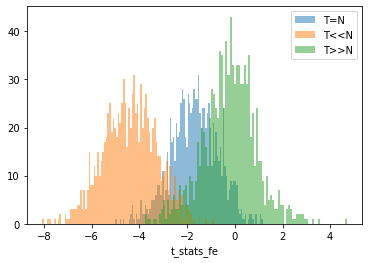

In [53]:
plt.hist(d[:,2],bins=100,alpha=0.5,label='T=N')
plt.hist(h[:,2],bins=100,alpha=0.5,label='T<<N')
plt.hist(l[:,2],bins=100,alpha=0.5,label='T>>N')
plt.legend()
plt.xlabel('t_stats_fe')
plt.show()

In the case of largeN and fixedT, we can observe Nickell bias, the FE estimator is inconsistent. Orange distirbution is far away from the standard normal distribution (may due to the large bias),which acounts for the rejection frequency of approximate 1.

When T and N are both large, the distribution of FE estimator is not centered at the true parameter value but closer, so the t-statistic is biased, which invalidates inference. 

When T>>N, the bias seems to disappear. Inference is unbiased.

In [98]:
N=70
delta=1
sigma2_eta=1
M=1000
T_range=range(5,305,10)
table3=np.zeros((len(T_range),3))
s=0
for T in T_range:
    table3[s,0],table3[s,1],table3[s,2],_=MC_study (T, N, alpha_true,delta,sigma2_eta,M,FE,False)
    s+=1 

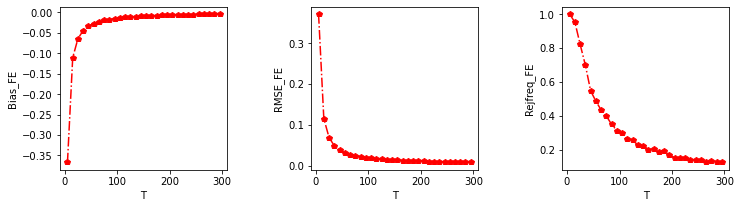

In [99]:
fig,axes=plt.subplots(1,3,figsize=(12,3))
axes[0].plot(T_range,table3[:,0], 'r-.p')
axes[0].set_xlabel('T')
axes[0].set_ylabel('Bias_FE')
axes[1].plot(T_range,table3[:,1], 'r-.p')
axes[1].set_xlabel('T')
axes[1].set_ylabel('RMSE_FE')
axes[2].plot(T_range,table3[:,2], 'r-.p')
axes[2].set_xlabel('T')
axes[2].set_ylabel('Rejfreq_FE')
plt.subplots_adjust(wspace=0.5)

In [104]:
table3[:,2]

array([1.   , 0.952, 0.821, 0.698, 0.547, 0.486, 0.434, 0.398, 0.349,
       0.312, 0.299, 0.262, 0.255, 0.228, 0.224, 0.201, 0.204, 0.185,
       0.194, 0.17 , 0.152, 0.149, 0.152, 0.14 , 0.139, 0.141, 0.125,
       0.131, 0.127, 0.125])

As T increases, the bias and RMSE both move towards zero, rejection frequency dereases from 1. So we can expect good properties of FE estimator when T keeps growing.

HPJ

In [113]:
a,b,c,d=MC_study (100, 100, 0.5,1,1,2000,HPJ,False)
e,f,g,h=MC_study (5, 100, 0.5,1,1,2000,HPJ,False)
i,j,k,l=MC_study(1000,10,0.5,1,1,2000,HPJ,False)

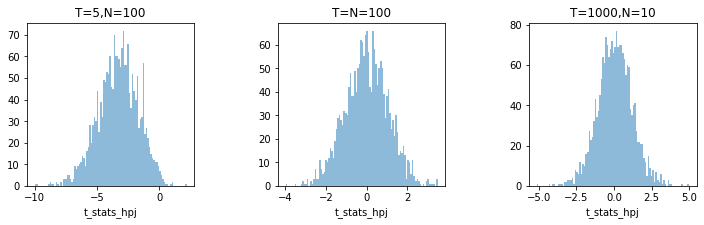

In [121]:
fig,axes=plt.subplots(1,3,figsize=(12,3))

axes[0].hist(h[:,2],bins=100,alpha=0.5)
axes[0].set_xlabel('t_stats_hpj')
axes[0].set_title('T=5,N=100')

axes[1].hist(d[:,2],bins=100,alpha=0.5)
axes[1].set_xlabel('t_stats_hpj')
axes[1].set_title('T=N=100')

axes[2].hist(l[:,2],bins=100,alpha=0.5)
axes[2].set_xlabel('t_stats_hpj')
axes[2].set_title('T=1000,N=10')

plt.subplots_adjust(wspace=0.5)

In [150]:
N=100
delta=1
sigma2_eta=1
M=1000
T_range=[5,7,10,20,30,60,100,200,300,400,1000]
table4=np.zeros((len(T_range),3))
table5=np.zeros((len(T_range),3))
s=0
for T in T_range:
    table4[s,0],table4[s,1],table4[s,2],_=MC_study (T, N, alpha_true,delta,sigma2_eta,M,HPJ,False)
    table5[s,0],table5[s,1],table5[s,2],_=MC_study (T, N, alpha_true,delta,sigma2_eta,M,FE,False)
    s+=1          

In [151]:
lala=pd.DataFrame(np.column_stack((T_range,table4,table5)),columns=['T','Bias_HPJ','RMSE_HPJ','Rejfreq_HPJ','Bias_FE','RMSE_FE','Rejfreq_FE'])
pd.options.display.float_format = '{:.6f}'.format
lala

,T,Bias_HPJ,RMSE_HPJ,Rejfreq_HPJ,Bias_FE,RMSE_FE,Rejfreq_FE
0,5.000000,-0.156625,0.172560,0.765000,-0.363327,0.366579,1.000000
1,7.000000,-0.076341,0.095822,0.476000,-0.256428,0.259280,1.000000
2,10.000000,0.003748,0.047475,0.166000,-0.172965,0.176008,1.000000
3,20.000000,0.005745,0.027521,0.132000,-0.080553,0.083432,0.963000
4,30.000000,0.003104,0.020136,0.113000,-0.052568,0.055170,0.892000
5,60.000000,0.000782,0.012401,0.079000,-0.025889,0.028357,0.620000
6,100.000000,-0.000001,0.009449,0.070000,-0.015570,0.017991,0.428000
7,200.000000,-0.000116,0.006410,0.059000,-0.007758,0.009946,0.242000
8,300.000000,0.000043,0.005188,0.060000,-0.005034,0.007159,0.167000
9,400.000000,0.000105,0.004398,0.053000,-0.003703,0.005725,0.142000


HPL estimator tries to deal with the bias and size distortion of FE estimator. We can observe that HPJ doesn't perform well when T is very small, like in the case of N=100,T=5, this bias-correction process only decrease approximate one third of the bias_FE, and rejection frequency is still way too large. But from T=10, bias is successfully corrected and RSME decreases significantly, and rejection frequency also makes a big move towards correct size. Comparing FE and HPJ as T increases, We can find that size distortion of HPJ decreases at a faster rate than FE, which means for fixed N we need less T for HPJ to conduct the valid inference. (Small and moderate T can cause sampling variation, which leads to wrong SE, then imprecise test statistics and distorted CI. Bootstrap is a way to fix it.)

**AH**

1.many instruments problem ( investigate the effect of T on the results) 

In [71]:
#fix N=50
N=50
delta=1
sigma2_eta=1
T_range=range(5,105,10)
table2=np.zeros((len(T_range),3))
M=1000
s=0
for T in T_range:
    table2[s,0],table2[s,1],table2[s,2],_=MC_study (T, N, alpha_true,delta,sigma2_eta,M,AH,False)
    s+=1          

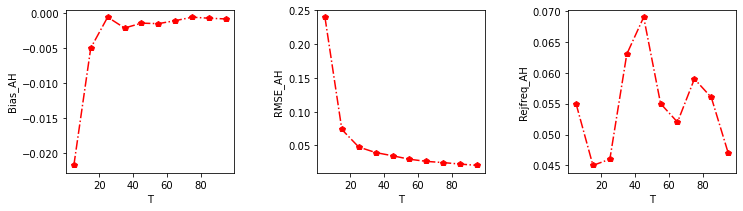

In [78]:
fig,axes=plt.subplots(1,3,figsize=(12,3))
axes[0].plot(T_range,table2[:,0], 'r-.p')
axes[0].set_xlabel('T')
axes[0].set_ylabel('Bias_AH')
axes[1].plot(T_range,table2[:,1], 'r-.p')
axes[1].set_xlabel('T')
axes[1].set_ylabel('RMSE_AH')
axes[2].plot(T_range,table2[:,2], 'r-.p')
axes[2].set_xlabel('T')
axes[2].set_ylabel('Rejfreq_AH')
plt.subplots_adjust(wspace=0.5)

When T is large compared with N, the AH estimator performs surprisingly well. The rejection frequency stays around 0.05, it almost has correct size for all T and N, bias decreases and rmse both decrease. We can infer that AH estimator (we are actually using GMM collapsed instruments?) suffers little from many instruments problem. This is because when we use IV style collapsed instruments, the number of moment condition is fixed at 2,not increasing with T.

2.weak instruments problem (investigate the effect of the ratio of sigma2_eta and sigma2_eps)

In [66]:
#investigate the change of sigma2_eta
N=100
delta=1
sigma2_eta_range=np.linspace(0.5,4,8)
M=1000
table=np.zeros((len(sigma2_eta_range),3))
T=4
s=0
for sig in sigma2_eta_range:
    table[s,0],table[s,1],table[s,2],_=MC_study (T, N, alpha_true,delta,sig,M,AH,False)
    s+=1          

In [67]:
print(table)

[[-0.00415645  0.18347481  0.05      ]
 [-0.00667483  0.2272709   0.051     ]
 [-0.00890377  0.26189542  0.054     ]
 [-0.01138739  0.2906353   0.055     ]
 [-0.01408195  0.31898011  0.057     ]
 [-0.01645516  0.34979766  0.056     ]
 [-0.01832116  0.38110482  0.058     ]
 [-0.01998219  0.41135728  0.057     ]]


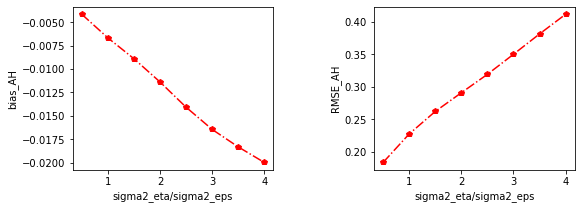

In [106]:
fig,axes=plt.subplots(1,2,figsize=(9,3))
axes[0].plot(sigma2_eta_range,table[:,0], 'r-.p')
axes[0].set_xlabel('sigma2_eta/sigma2_eps')
axes[0].set_ylabel('bias_AH')
axes[1].plot(sigma2_eta_range,table[:,1], 'r-.p')
axes[1].set_xlabel('sigma2_eta/sigma2_eps')
axes[1].set_ylabel('RMSE_AH')
plt.subplots_adjust(wspace=0.5)

All IV/GMM methods are subject to the problem of weak instruments, theoretically the performance of GMM or AH estiamtor can deteriorate in the following two cases:first, alpha increases towards unity; second, sigma2_eta increases relative to sigma2_eps. Here we change the ratio of this two variance, and find that the bias and RMSE are both increasing as the ratio grows.(high ratio corresponds to weak instrument)

3. the validity of infernece ( from t-statistic )

In [79]:
a,b,c,d=MC_study (100, 100, 0.5,1,1,1000,AH,False)
e,f,g,h=MC_study (5, 100, 0.5,1,1,1000,AH,False)
i,j,k,l=MC_study(1000,10,0.5,1,1,1000,AH,False)

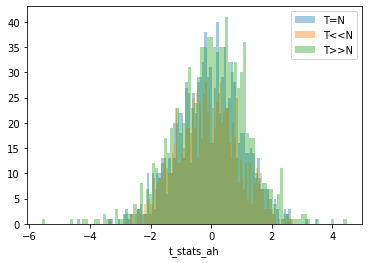

In [86]:
plt.hist(d[:,2],bins=100,alpha=0.4,label='T=N')
plt.hist(h[:,2],bins=100,alpha=0.4,label='T<<N')
plt.hist(l[:,2],bins=100,alpha=0.4,label='T>>N')
plt.legend()
plt.xlabel('t_stats_ah')
plt.show()

Its distribution is close to standard normal distribution, the rejection frequency is also close to significant level, hence we can use AH estimator to conduct valid inference.

------------------------------------

In [159]:
N_range=[100,150]
T_range=[6,15]
delta_range=[0.5,1]
sigma2_eta_range=[1,2]
reportt=np.zeros((16,16))
alpha_true=0.5
M=4000
columns_name=['T','N','Delta','sigma2_eta','alpha_FE','se_FE','alpha_FE2','se_FE2',
              'alpha_AH','se_AH','alpha_AH2','se_AH2',
              'alpha_HPJ','se_HPJ','alpha_HPJ2','se_HPJ2']
m=0
for T in T_range:
    for N in N_range:
        for delta in delta_range:
            for sigma2_eta in sigma2_eta_range:
                np.random.seed(123)
                mDataY = GenrData (T, N, alpha_true, delta,sigma2_eta)
                y=mDataY[1:,:]  
                x=mDataY[:-1,:]
                report[m,0],report[m,1],report[m,2],report[m,3]=T,N,delta,sigma2_eta
                report[m,4],report[m,5]=FE(y,x)
                report[m,8],report[m,9]=AH(y,x)
                report[m,12],report[m,13]=HPJ(y,x)
                y_demeaned=Demean(y,1)
                x_demeaned=Demean(x,1)
                report[m,6],report[m,7]=FE(y_demeaned,x_demeaned)
                report[m,10],report[m,11]=AH(y_demeaned,x_demeaned)
                report[m,14],report[m,15]=HPJ(y_demeaned,x_demeaned)
                m=m+1
Reportt=pd.DataFrame(report,columns=columns_name)

In [160]:
Reportt

,T,N,Delta,sigma2_eta,alpha_FE,se_FE,alpha_FE2,se_FE2,alpha_AH,se_AH,alpha_AH2,se_AH2,alpha_HPJ,se_HPJ,alpha_HPJ2,se_HPJ2
0,6.000000,100.000000,0.500000,1.000000,0.309879,0.045077,0.308808,0.045824,0.414544,0.213393,0.383114,0.217259,0.551750,0.044349,0.560757,0.045128
1,6.000000,100.000000,0.500000,2.000000,0.338086,0.042994,0.337572,0.043578,-0.552737,4.038046,-1.982804,14.519577,0.575553,0.041919,0.585257,0.042782
2,6.000000,100.000000,1.000000,1.000000,0.264952,0.047520,0.262511,0.048457,0.428957,0.116843,0.413651,0.116269,0.519575,0.048585,0.524389,0.049125
3,6.000000,100.000000,1.000000,2.000000,0.264952,0.047520,0.262511,0.048457,0.397259,0.147709,0.379938,0.146586,0.519575,0.048585,0.524389,0.049125
4,6.000000,150.000000,0.500000,1.000000,0.261201,0.035006,0.262133,0.035663,0.368602,0.133106,0.355547,0.139137,0.505209,0.038880,0.509698,0.039483
5,6.000000,150.000000,0.500000,2.000000,0.289994,0.034499,0.290952,0.035084,0.233090,0.592192,0.197878,0.665678,0.530931,0.037948,0.535615,0.038518
6,6.000000,150.000000,1.000000,1.000000,0.225075,0.033613,0.225931,0.034244,0.426803,0.082994,0.423656,0.084958,0.462287,0.036836,0.466783,0.037409
7,6.000000,150.000000,1.000000,2.000000,0.225075,0.033613,0.225931,0.034244,0.403597,0.106211,0.397998,0.108778,0.462287,0.036836,0.466783,0.037409
8,15.000000,100.000000,0.500000,1.000000,0.441702,0.024480,0.442156,0.024551,0.547667,0.067438,0.543137,0.068883,0.518103,0.023881,0.520104,0.023887
9,15.000000,100.000000,0.500000,2.000000,0.449313,0.023702,0.449907,0.023746,0.554950,0.107230,0.549059,0.110095,0.523215,0.022977,0.525426,0.022944


Results using demeaned data and original data are almost the same. Because when we generate data, we exclude cross-sectional dependence.